In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv("/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/data/dataset/EnergyData.csv",
                    index_col=[0], parse_dates=[0])
data = data.sort_index()
columnstodrop = ['respondent','respondent-name','fueltype','type-name','value-units']
data.drop(columns=columnstodrop, axis=1, inplace=True) 
data.head()

,value
period,
2022-01-01 00:00:00,3962
2022-01-01 01:00:00,3970
2022-01-01 02:00:00,3963
2022-01-01 03:00:00,3750
2022-01-01 04:00:00,3513


### Feature Engineering

In [3]:
df = data.copy()
df['Seconds'] = df.index.map(pd.Timestamp.timestamp) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,value,Seconds
period,,
2022-01-01 00:00:00,3962,1.640995e+09
2022-01-01 01:00:00,3970,1.640999e+09
2022-01-01 02:00:00,3963,1.641002e+09
2022-01-01 03:00:00,3750,1.641006e+09
2022-01-01 04:00:00,3513,1.641010e+09


In [4]:
from datetime import timedelta
# Constants for cyclic features
day = 60 * 60 * 24
year = timedelta(days=365.2425).total_seconds()
hour = 60 * 60
minute = 60 

# Extract cyclic features
df['Day sin'] = np.sin(2 * np.pi * df['Seconds'] / day)
df['Day cos'] = np.cos(2 * np.pi * df['Seconds'] / day)
df['Year sin'] = np.sin(2 * np.pi * df['Seconds'] / year)
df['Year cos'] = np.cos(2 * np.pi * df['Seconds'] / year)

# Extract hours and minutes
df['Hour'] = (df['Seconds'] // hour) % 24
df['Minute'] = (df['Seconds'] // minute) % 60

# Cyclic encoding for hours and minutes
df['Hour sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Convert seconds to datetime to extract month
df['Datetime'] = pd.to_datetime(df['Seconds'], unit='s', origin='unix')
df['Month'] = df['Datetime'].dt.month

# Cyclic encoding for months
df['Month sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Drop unnecessary columns
df = df.drop(['Seconds', 'Hour', 'Minute', 'Month', 'Datetime'], axis=1) 
df.head()

,value,Day sin,Day cos,Year sin,Year cos,Hour sin,Hour cos,Minute sin,Minute cos,Month sin,Month cos
period,,,,,,,,,,,
2022-01-01 00:00:00,3962,-8.652299e-12,1.000000,0.006709,0.999977,0.000000,1.000000,0.0,1.0,0.5,0.866025
2022-01-01 01:00:00,3970,2.588190e-01,0.965926,0.007426,0.999972,0.258819,0.965926,0.0,1.0,0.5,0.866025
2022-01-01 02:00:00,3963,5.000000e-01,0.866025,0.008143,0.999967,0.500000,0.866025,0.0,1.0,0.5,0.866025
2022-01-01 03:00:00,3750,7.071068e-01,0.707107,0.008859,0.999961,0.707107,0.707107,0.0,1.0,0.5,0.866025
2022-01-01 04:00:00,3513,8.660254e-01,0.500000,0.009576,0.999954,0.866025,0.500000,0.0,1.0,0.5,0.866025


In [5]:
# Add rolling mean and rolling std
df['rolling_mean_3h'] = df['value'].rolling(window=3).mean()
df['rolling_std_3h'] = df['value'].rolling(window=3).std()

df['rolling_mean_24h'] = df['value'].rolling(window=24).mean()  
df['rolling_std_24h'] = df['value'].rolling(window=24).std()
 
df['rolling_mean_3h'] = df['rolling_mean_3h'].ffill()
df['rolling_std_3h'] = df['rolling_std_3h'].ffill()

df['rolling_mean_24h'] = df['rolling_mean_24h'].ffill()
df['rolling_std_24h'] = df['rolling_std_24h'].ffill()
 
df = df.fillna(method='ffill') 
df.head() 

/tmp/ipykernel_5968/1248396922.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,value,Day sin,Day cos,Year sin,Year cos,Hour sin,Hour cos,Minute sin,Minute cos,Month sin,Month cos,rolling_mean_3h,rolling_std_3h,rolling_mean_24h,rolling_std_24h
period,,,,,,,,,,,,,,,
2022-01-01 00:00:00,3962,-8.652299e-12,1.000000,0.006709,0.999977,0.000000,1.000000,0.0,1.0,0.5,0.866025,NaN,NaN,NaN,NaN
2022-01-01 01:00:00,3970,2.588190e-01,0.965926,0.007426,0.999972,0.258819,0.965926,0.0,1.0,0.5,0.866025,NaN,NaN,NaN,NaN
2022-01-01 02:00:00,3963,5.000000e-01,0.866025,0.008143,0.999967,0.500000,0.866025,0.0,1.0,0.5,0.866025,3965.000000,4.358899,NaN,NaN
2022-01-01 03:00:00,3750,7.071068e-01,0.707107,0.008859,0.999961,0.707107,0.707107,0.0,1.0,0.5,0.866025,3894.333333,125.045325,NaN,NaN
2022-01-01 04:00:00,3513,8.660254e-01,0.500000,0.009576,0.999954,0.866025,0.500000,0.0,1.0,0.5,0.866025,3742.000000,225.106641,NaN,NaN


In [6]:
# Add lag features
for lag in range(1, 4): 
    df[f'lag_{lag}'] = df['value'].shift(lag)

# Fill missing values first with forward fill, then backfill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True) 
df.head()

/tmp/ipykernel_5968/902158168.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_5968/902158168.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


,value,Day sin,Day cos,Year sin,Year cos,Hour sin,Hour cos,Minute sin,Minute cos,Month sin,Month cos,rolling_mean_3h,rolling_std_3h,rolling_mean_24h,rolling_std_24h,lag_1,lag_2,lag_3
period,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,3962,-8.652299e-12,1.000000,0.006709,0.999977,0.000000,1.000000,0.0,1.0,0.5,0.866025,3965.000000,4.358899,3260.458333,546.003502,3962.0,3962.0,3962.0
2022-01-01 01:00:00,3970,2.588190e-01,0.965926,0.007426,0.999972,0.258819,0.965926,0.0,1.0,0.5,0.866025,3965.000000,4.358899,3260.458333,546.003502,3962.0,3962.0,3962.0
2022-01-01 02:00:00,3963,5.000000e-01,0.866025,0.008143,0.999967,0.500000,0.866025,0.0,1.0,0.5,0.866025,3965.000000,4.358899,3260.458333,546.003502,3970.0,3962.0,3962.0
2022-01-01 03:00:00,3750,7.071068e-01,0.707107,0.008859,0.999961,0.707107,0.707107,0.0,1.0,0.5,0.866025,3894.333333,125.045325,3260.458333,546.003502,3963.0,3970.0,3962.0
2022-01-01 04:00:00,3513,8.660254e-01,0.500000,0.009576,0.999954,0.866025,0.500000,0.0,1.0,0.5,0.866025,3742.000000,225.106641,3260.458333,546.003502,3750.0,3963.0,3970.0


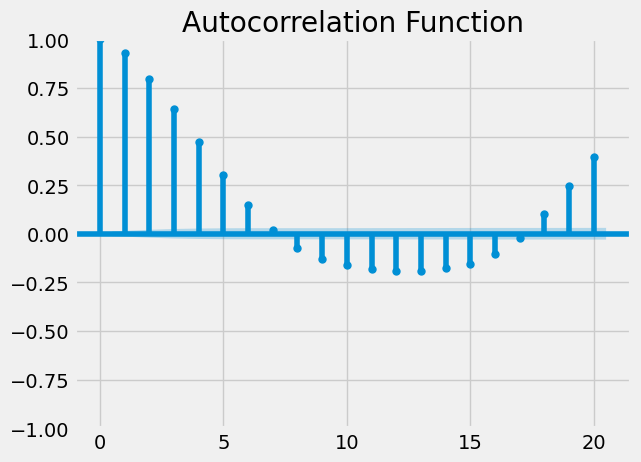

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function (ACF)
plot_acf(df['value'], lags=20)  
plt.title('Autocorrelation Function')
plt.show()

**Insights from Autocorrelation Plot**

1. **Strong Positive Autocorrelation at Lower Lags:**
   - The plot exhibits high autocorrelation values at lower lags, indicating that the energy generation values are strongly influenced by their recent past observations.

2. **Gradual Decay of Autocorrelation:**
   - The autocorrelation decreases gradually instead of dropping sharply, suggesting the presence of non-stationarity or long-term dependencies in the time series.

3. **Seasonal Pattern:**
   - The spikes in autocorrelation at specific lags (e.g., lag 20) may indicate periodic or seasonal patterns in energy generation, requiring careful modeling to capture these effects.

4. **Implications for Forecasting Models:**
   - Non-stationarity and seasonality suggest the need for preprocessing steps like differencing or incorporating seasonal components before applying models such as ARIMA or LSTM.  


In [8]:
df.describe()

,value,Day sin,Day cos,Year sin,Year cos,Hour sin,Hour cos,Minute sin,Minute cos,Month sin,Month cos,rolling_mean_3h,rolling_std_3h,rolling_mean_24h,rolling_std_24h,lag_1,lag_2,lag_3
count,25561.000000,2.556100e+04,2.556100e+04,25561.000000,25561.000000,2.556100e+04,2.556100e+04,25561.0,25561.0,2.556100e+04,2.556100e+04,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000
mean,3036.591409,-1.854396e-14,3.912210e-05,0.007255,-0.027539,-1.855511e-17,3.912210e-05,0.0,1.0,-4.719327e-03,-3.103767e-02,3036.605571,163.503559,3036.745688,529.925077,3036.605962,3036.618951,3036.633465
std,625.980099,7.071068e-01,7.071344e-01,0.715492,0.698068,7.071068e-01,7.071344e-01,0.0,0.0,7.159985e-01,6.974236e-01,601.549582,135.207502,315.705689,155.044350,625.997290,626.013047,626.030201
min,0.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,0.0,1.0,-1.000000e+00,-1.000000e+00,862.000000,0.577350,1823.500000,97.679591,0.000000,0.000000,0.000000
25%,2577.000000,-7.071068e-01,-7.071068e-01,-0.722506,-0.722414,-7.071068e-01,-7.071068e-01,0.0,1.0,-8.660254e-01,-8.660254e-01,2597.333333,59.002825,2823.833333,427.794392,2577.000000,2577.000000,2577.000000
50%,3106.000000,-6.735317e-14,-9.292657e-14,0.043975,-0.043900,0.000000e+00,6.123234e-17,0.0,1.0,1.224647e-16,-1.836970e-16,3101.333333,122.000000,3051.166667,520.278159,3106.000000,3106.000000,3106.000000
75%,3506.000000,7.071068e-01,7.071068e-01,0.722466,0.658978,7.071068e-01,7.071068e-01,0.0,1.0,8.660254e-01,5.000000e-01,3486.666667,236.220942,3274.833333,615.865598,3506.000000,3506.000000,3506.000000
max,5231.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,0.0,1.0,1.000000e+00,1.000000e+00,5185.000000,1984.614404,3912.875000,1185.112320,5231.000000,5231.000000,5231.000000


In [9]:
df.isnull().sum()

value               0
Day sin             0
Day cos             0
Year sin            0
Year cos            0
Hour sin            0
Hour cos            0
Minute sin          0
Minute cos          0
Month sin           0
Month cos           0
rolling_mean_3h     0
rolling_std_3h      0
rolling_mean_24h    0
rolling_std_24h     0
lag_1               0
lag_2               0
lag_3               0
dtype: int64

Train Set:
(21168, 18)

Test Set:
(4393, 18)


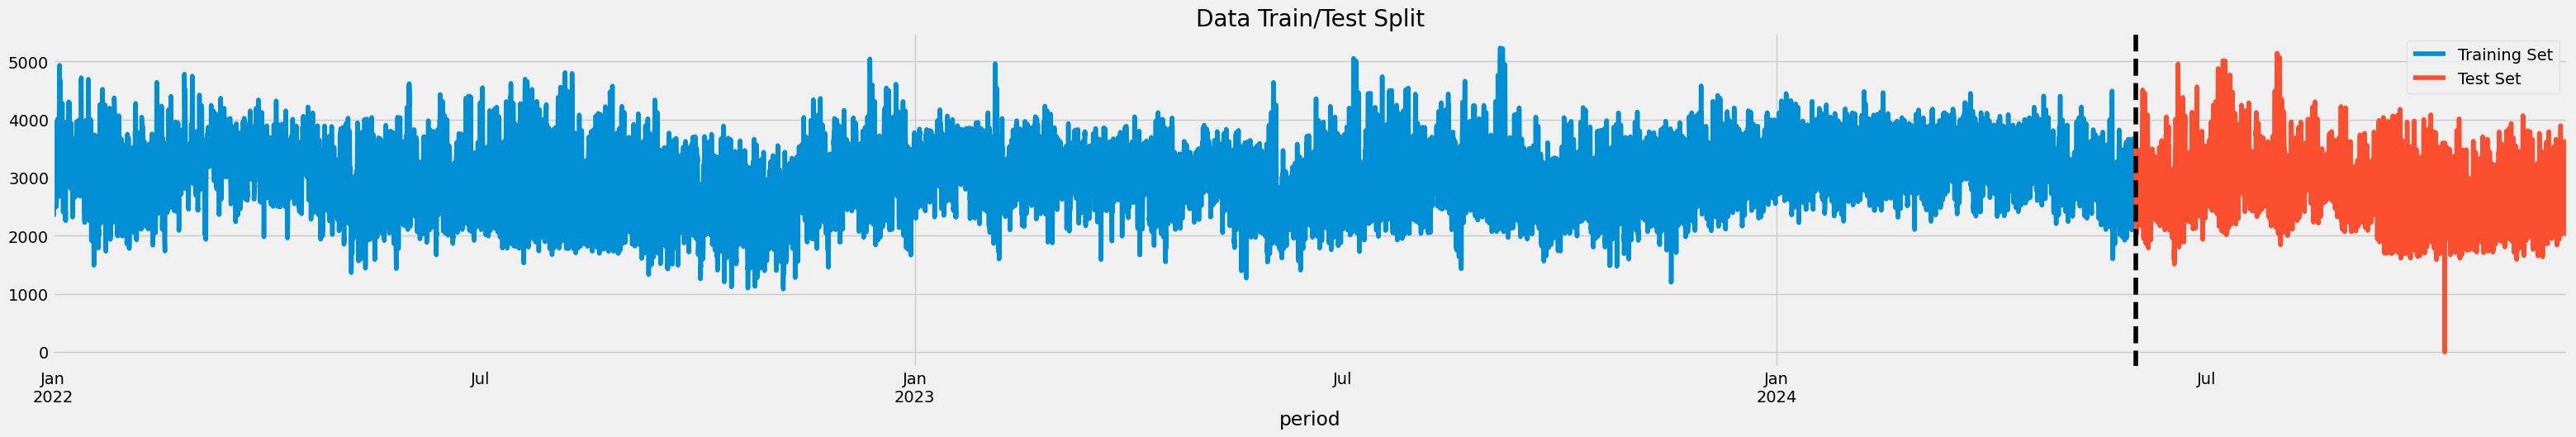

In [10]:
train = df.loc[df.index < '06-01-2024']
test = df.loc[df.index >= '06-01-2024']

print("Train Set:")
print(train.shape) 
print("\nTest Set:")
print(test.shape)

fig, ax = plt.subplots(figsize=(35, 5))
train['value'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['value'].plot(ax=ax, label='Test Set')
ax.axvline('06-01-2024', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [11]:
df.columns

Index(['value', 'Day sin', 'Day cos', 'Year sin', 'Year cos', 'Hour sin',
       'Hour cos', 'Minute sin', 'Minute cos', 'Month sin', 'Month cos',
       'rolling_mean_3h', 'rolling_std_3h', 'rolling_mean_24h',
       'rolling_std_24h', 'lag_1', 'lag_2', 'lag_3'],
      dtype='object')

In [ ]:
FEATURES = ['Day sin', 'Day cos', 'Year sin', 'Year cos', 'Hour sin',
       'Hour cos', 'Minute sin', 'Minute cos', 'Month sin', 'Month cos',
       'rolling_mean_3h', 'rolling_std_3h', 'rolling_mean_24h',
       'rolling_std_24h', 'lag_1', 'lag_2', 'lag_3']
TARGET = 'value' 
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]
X_train.shape,X_test.shape, y_train.shape,y_test.shape

((21168, 17), (4393, 17), (21168,), (4393,))

### XGBoost Model

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
import xgboost as xgb 
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    colsample_bytree=0.7,
    min_child_weight=5,
    reg_alpha=1,
    reg_lambda=1,
    gamma=1,
    early_stopping_rounds=5,
    eval_metric="rmse"  
) 
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)
print(reg)

[0]	validation_0-rmse:600.83405	validation_1-rmse:650.91986
[100]	validation_0-rmse:105.20042	validation_1-rmse:116.50744
[200]	validation_0-rmse:78.21559	validation_1-rmse:91.70079
[300]	validation_0-rmse:66.20958	validation_1-rmse:83.27348
[400]	validation_0-rmse:57.15524	validation_1-rmse:76.97079
[500]	validation_0-rmse:50.39856	validation_1-rmse:72.34418
[600]	validation_0-rmse:45.27854	validation_1-rmse:69.15952
[700]	validation_0-rmse:41.39956	validation_1-rmse:66.67514
[800]	validation_0-rmse:38.20278	validation_1-rmse:64.70445
[900]	validation_0-rmse:35.42843	validation_1-rmse:63.13522
[999]	validation_0-rmse:33.03137	validation_1-rmse:61.65337
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
    

In [14]:
import joblib
joblib.dump(reg, "/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/notebooks/models/xgboost.pkl")

['/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/notebooks/models/xgboost.pkl']

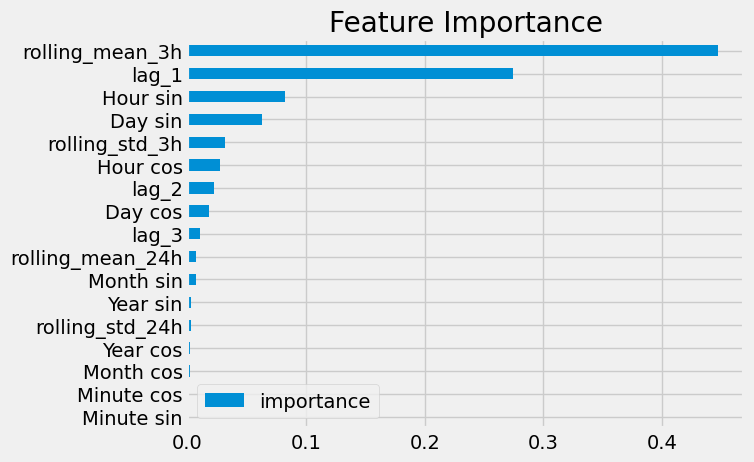

In [17]:
fi = pd.DataFrame(
    reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/tmp/ipykernel_8030/3851314363.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = y_pred_df['prediction']


                      prediction
period                          
2024-06-01 00:00:00  3724.239746
2024-06-01 01:00:00  3718.581055
2024-06-01 02:00:00  3554.348633
2024-06-01 03:00:00  3283.912842
2024-06-01 04:00:00  2951.783203


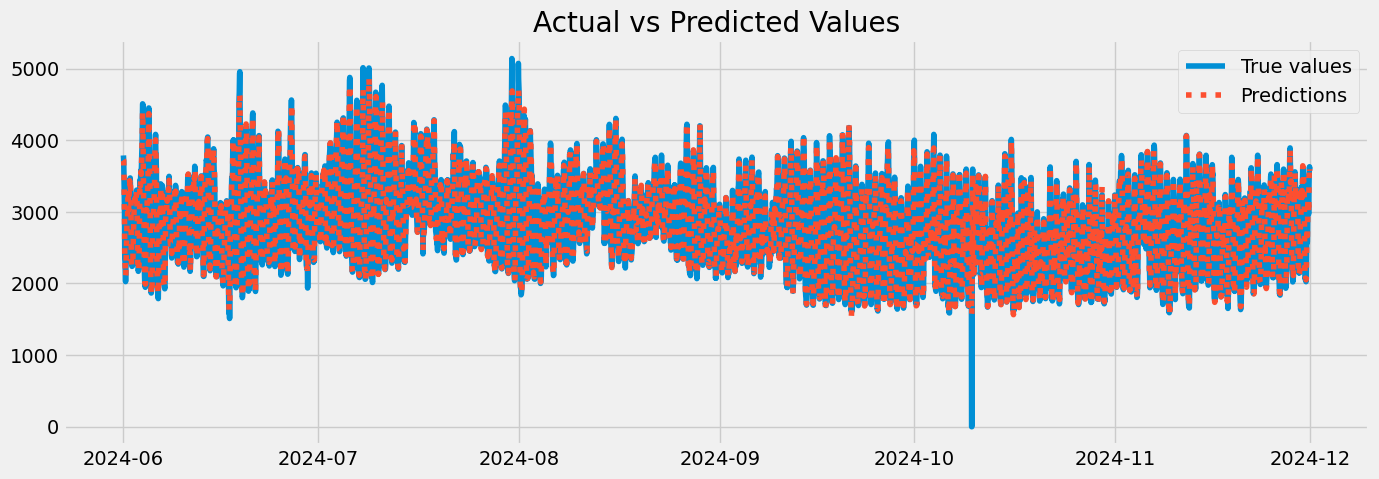

In [18]:
# Make predictions on the test set
y_pred_test = reg.predict(X_test)
# Make predictions on the train set 
y_pred_train = reg.predict(X_train) 
# Create a DataFrame for predictions with proper index alignment
y_pred_df = pd.DataFrame(y_pred_test, index=X_test.index, columns=['prediction'])

# Ensure the index alignment and add the prediction column to the test DataFrame
test['prediction'] = y_pred_df['prediction']

# Display the predictions
print(test[['prediction']].head())

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(test[TARGET], label='True values')
plt.plot(test['prediction'], label='Predictions', linestyle='dotted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()


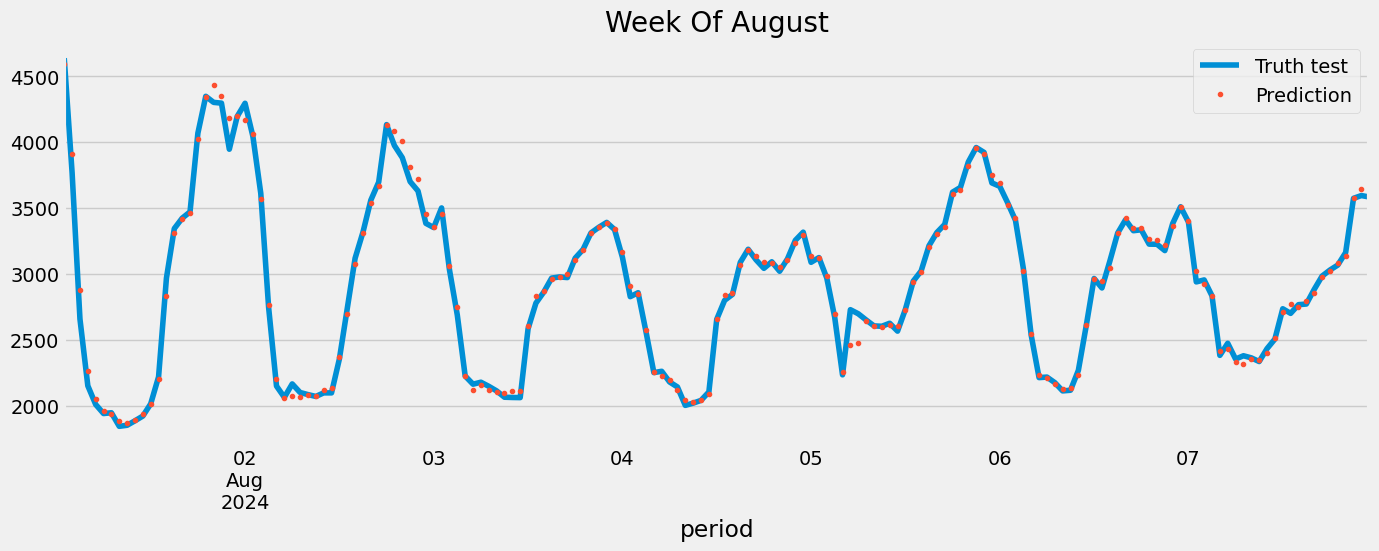

In [19]:
ax = test.loc[(test.index > '08-01-2024') & (test.index < '08-08-2024')]['value'] \
    .plot(figsize=(15, 5), title='Week Of August')
test.loc[(test.index > '08-01-2024') & (test.index < '08-08-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth test','Prediction'])
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
# Calculate RMSE, MAE, and MSE for the train set
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
# Print the metrics
# Calculate RMSE, MAE, and MSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
# Print the metrics
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Train R2: {r2_train:.4f}")
print(f"Test R2: {r2_test:.4f}")

Train RMSE: 33.0432
Train MAE: 23.5319
Train MSE: 1091.8503
Test RMSE: 61.6488
Test MAE: 30.6254
Test MSE: 3800.5774
Train R2: 0.9971
Test R2: 0.9903


### Combined Model Metrics

In [ ]:
metrics = {
    "Model": ["GRU", "GRU", "GRU", "LSTM", "LSTM", "LSTM", "CONV", "CONV", "CONV","XGBOOST",'XGBOOST'],
    "Dataset": ["Train", "Validation", "Test", "Train", "Validation", "Test", "Train", "Validation", "Test","Train","Test"],
    "MAE": [128.074907, 120.378577, 122.566104, 129.504066, 132.078705, 120.155095, 134.774344, 118.818230, 126.197184,23.5319, 30.6254],
    "MSE": [28845.085620, 23978.625464, 28192.139937, 29423.001937, 27574.907890, 27652.529745, 
            31422.307641, 23444.142409, 29203.894119,1091.8503, 3800.5774],
    "RMSE": [169.838410, 154.850332, 167.905152, 171.531344, 166.056942, 166.290498, 177.263385, 
             153.114801, 170.891469,33.0432, 61.6488],
    "R²": [0.925734, 0.911802, 0.926688, 0.924246, 0.898574, 0.928091, 0.919098, 0.913768, 0.924056,0.9971, 0.9903]
} 
metrics_df = pd.DataFrame(data)
metrics_df

,Model,Dataset,MAE,MSE,RMSE,R²
0,GRU,Train,128.074907,28845.085620,169.838410,0.925734
1,GRU,Validation,120.378577,23978.625464,154.850332,0.911802
2,GRU,Test,122.566104,28192.139937,167.905152,0.926688
3,LSTM,Train,129.504066,29423.001937,171.531344,0.924246
4,LSTM,Validation,132.078705,27574.907890,166.056942,0.898574
5,LSTM,Test,120.155095,27652.529745,166.290498,0.928091
6,CONV,Train,134.774344,31422.307641,177.263385,0.919098
7,CONV,Validation,118.818230,23444.142409,153.114801,0.913768
8,CONV,Test,126.197184,29203.894119,170.891469,0.924056
9,XGBOOST,Train,23.531900,1091.850300,33.043200,0.997100
